# Performance on a Skewed Dataset

In [1]:
import pandas as pd
from keystrokes.utils.model_utils import load_model
from sklearn.utils import resample, shuffle

TEST_SET_URL = "https://www.dropbox.com/s/wr7dk90rqqdfdda/test_data.csv?dl=1"
MODEL_URL = "https://www.dropbox.com/s/yiitiwjct2zxhfi/model.joblib?dl=1"

In [2]:
def downsample_df(df):
    df_majority = df[df.labels == 0]
    df_minority = df[df.labels == 1]

    # Downsample minority class
    df_minority_downsampled = resample(
        df_minority, replace=False, n_samples=int(len(df_majority) * 0.01), random_state=123
    )

    # Combine minority class with majority class
    return shuffle(pd.concat([df_majority, df_minority_downsampled]))

model = load_model(MODEL_URL)
df = downsample_df(pd.read_csv(TEST_SET_URL))
y = df['labels']
X = df.drop(columns='labels')

Model downloaded successfully.


In [3]:
y.value_counts()

labels
0    30024
1      300
Name: count, dtype: int64

We have ~ 1% intrusions or positive examples in the data.

### Make predictions


In [4]:
y_pred_proba = model.predict_proba(X)[:,1]
y_pred = (y_pred_proba >= 0.5).astype(int)

## Metrics

In [5]:

import matplotlib.pyplot as plt

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
)


### Compute Metrics


In [7]:
accuracy = accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred_proba)
cf_matrix = confusion_matrix(y, y_pred)
precision, recall, _ = precision_recall_curve(y, y_pred_proba)
auc_pr = auc(recall, precision)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("AUC-ROC: %.2f" % roc_auc)
print("AUC-PR: %.2f" % auc_pr)

Accuracy: 91.90%
AUC-ROC: 0.97
AUC-PR: 0.64


In [14]:
def plot_confusion_matrices(thresh, y, y_pred_proba):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    ConfusionMatrixDisplay.from_predictions(
        y_true=y, y_pred=(y_pred_proba >= thresh).astype(int), display_labels=["same", "different"], ax=ax1
    )
    ConfusionMatrixDisplay.from_predictions(
        y_true=y, y_pred=(y_pred_proba >= thresh).astype(int), normalize="true", display_labels=["same", "different"], ax=ax2
    )

    plt.suptitle('Comparing Raw and Normalized Confusion Matrices at Threshold ' + str(thresh))
    plt.show()



### Confusion Matrix - threshold = 0.5

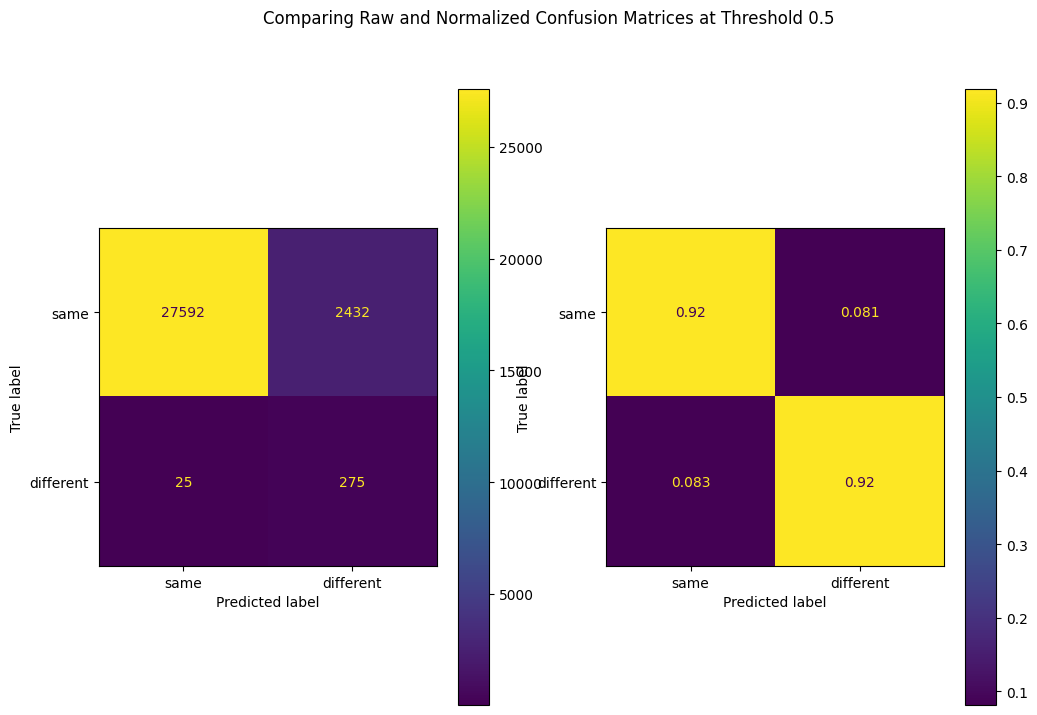

In [15]:
plot_confusion_matrices(0.5, y, y_pred_proba)

### Confusion Matrix - threshold = 0.9

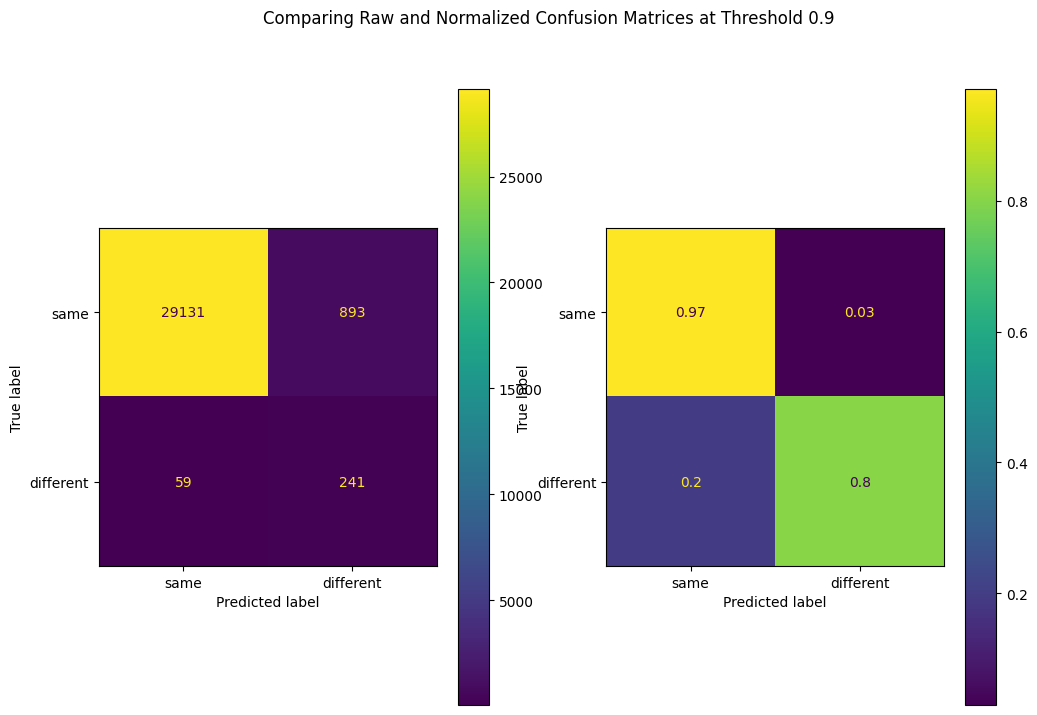

In [23]:
plot_confusion_matrices(0.9, y, y_pred_proba)

### PR and ROC Curves

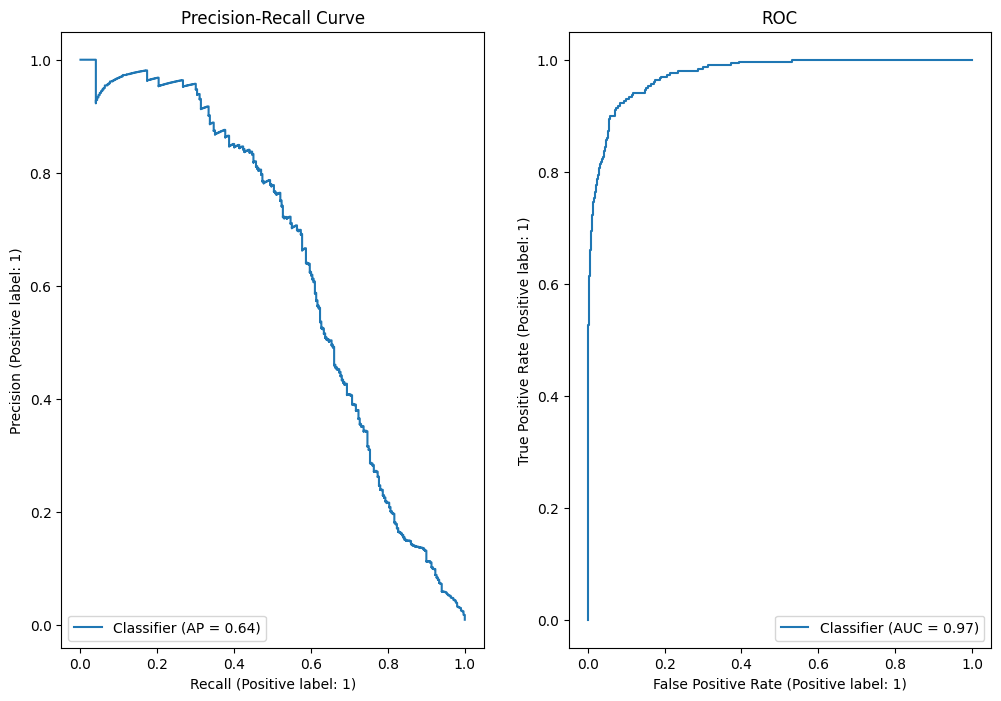

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

PrecisionRecallDisplay.from_predictions(
    y_true=y, y_pred=y_pred_proba, ax=ax1
)
RocCurveDisplay.from_predictions(
    y_true=y, y_pred=y_pred_proba, ax=ax2
)
ax1.set_title('Precision-Recall Curve')
ax2.set_title('ROC')
plt.show()